# Multilayer Perceptron (MLP)
In this notebook, we build a multilayer perceptron for digit recognition trained on the MNIST dataset. We used [Deep-Learning-Experiments](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/versions/2022/mlp/python/mlp_pytorch_demo.ipynb) as reference.

In [29]:
# Import necessary libraries
import os
import torch
from torch import nn
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import Accuracy
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
#from einops import rearrange # We will not use this since it does not work with to_torchscript()
from argparse import ArgumentParser
from PIL import Image
from matplotlib import pyplot as plt

c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


We create a simple 4-layer multilayer perceptron for digit recognition. We use torch.nn.Module as superclass to remove boilerplate code. The number of input features corresponds to the input image size for the MNIST dataset, which is $28\times28$ (It is grayscale so we do not need to multiply by 3). The number of nodes in the hidden layers is set to $256$. Finally, the number of classes is set to $10$, corresponding to the number of possible digits in the MNIST dataset.

In [30]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, num_features=28*28, num_hidden=256, num_classes=10):
        # Initiate the nn.Module superclass
        super().__init__()

        # Build the layers of the MLP
        self.fc_in = nn.Linear(num_features,num_hidden)
        self.fc_hid = nn.Linear(num_hidden,num_hidden)
        self.fc_out = nn.Linear(num_hidden,num_classes)

        # Set up the activation function (we choose ReLU) and the softmax function (for the output).
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # Comment if using CrossEntropyLoss()

    def forward(self, x):
        # Flatten the input x from bx1x28x28 to 1x1*28*28=784 to match num_features.
        #y = rearrange(x, 'b c h w -> b (c h w)') # Intuitive version using einops
        y = torch.flatten(x, 1)

        # Feed the rearranged input data to the input layer, then feed to the activation function.
        y = self.fc_in(y)
        y = self.relu(y)

        # Do the same for the 2 hidden layers.
        y = self.fc_hid(y)
        y = self.relu(y)
        y = self.fc_hid(y)
        y = self.relu(y)

        # Feed the resulting tensor into the output layer. ReLU activation function is not needed since softmax is used for it.
        y = self.fc_out(y)
        y = self.softmax(y) # Comment if using CrossEntropyLoss()

        return y

We now perform the necessary preparations for the dataset and training, using the PyTorch Lightning module.

In [31]:
class MNISTMLPModel(pl.LightningModule):
    def __init__(self, lr=0.001, batch_size=64, num_workers=1, max_epochs=30, model=MultilayerPerceptron, optim="adam"):
        # Initiate LightningModule superclass
        super().__init__()
        self.train_step_outputs = []
        self.test_step_outputs = []

        # Set up other parameters
        self.save_hyperparameters()
        self.model = model()

        # Set up loss function (Mean Squared Error) and accuracy
        self.loss = nn.MSELoss()
        #self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=10)
        self.optim = optim 

    def forward(self,x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        # Perform one-hot encoding on y first
        y = self.mnist_one_hot(y) # Comment if using CrossEntropyLoss()
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.train_step_outputs.append({"loss": loss})
        return loss
    
    def on_train_epoch_end(self):
        avg_loss = torch.stack([x["loss"] for x in self.train_step_outputs]).mean()
        print(f'Train loss: {avg_loss}')
        self.train_step_outputs.clear()
        self.log("train_loss", avg_loss, on_epoch=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        # Perform one-hot encoding on y first. We keep the original y for the accuracy
        y_oh = self.mnist_one_hot(y) # Comment if using CrossEntropyLoss()
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y_oh) # Comment if using CrossEntropyLoss()
        #loss = self.loss(y_hat, y) # Uncomment if using CrossEntropyLoss()
        # We get the predictions through argmax
        y_preds = torch.argmax(y_hat, dim=1)
        acc = self.accuracy(y, y_preds) * 100. # Comment if using CrossEntropyLoss()
        #acc = self.accuracy(y, y_hat) * 100. # Uncomment if using CrossEntropyLoss()
        self.test_step_outputs.append({"y_hat": y_hat, "test_loss": loss, "test_acc": acc})
        return y_hat, loss, acc
    
    def on_test_epoch_end(self):
        avg_loss = torch.stack([x["test_loss"] for x in self.test_step_outputs]).mean()
        avg_acc = torch.stack([x["test_acc"] for x in self.test_step_outputs]).mean()
        print(f'Test loss: {avg_loss}')
        print(f'Test accuracy: {avg_acc}')
        self.test_step_outputs.clear()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", avg_acc, on_epoch=True, prog_bar=True)

    def validation_step(self, batch, batch_idx):
       return self.test_step(batch, batch_idx)

    def on_validation_epoch_end(self):
        return self.on_test_epoch_end()
    
    def configure_optimizers(self):
        if self.optim == "adam":
            optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        elif self.optim == "sgd":
            optimizer = SGD(self.parameters(), lr=self.hparams.lr)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler]
    
    # Settings from https://nextjournal.com/gkoehler/pytorch-mnist
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.MNIST('/files/', train=True, download=True,
                                        transform=torchvision.transforms.ToTensor()), 
                                        batch_size=self.hparams.batch_size, shuffle=True, pin_memory=True)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.MNIST('/files/', train=False, download=True,
                                        transform=torchvision.transforms.ToTensor()), 
                                        batch_size=self.hparams.batch_size, shuffle=False, pin_memory=True)
    
    def val_dataloader(self):
        return self.test_dataloader()
    
    def setup(self, stage=None):
        self.train_dataloader()
        self.test_dataloader()

    # Perform MNIST-specific one-hot encoding
    def mnist_one_hot(self, x):
        device = 'cuda' if 'cuda' in str(x.device) else 'cpu'
        y_oh = torch.zeros(size=(x.shape[0],10), device=device)
        y_oh.to(device)
        for i, y in enumerate(x):
            y_oh[i,y] = 1
        return y_oh.float()

After setting up the model, the datasets, and the train/test/validation configurations, we set up the arguments.

In [32]:
def get_args():
    parser = ArgumentParser(description="PyTorch Lightning MNIST Example")
    parser.add_argument("--epochs", type=int, default=30, help="num epochs")
    parser.add_argument("--batch-size", type=int, default=64, help="batch size")
    parser.add_argument("--lr", type=float, default=0.001, help="learning rate")

    parser.add_argument("--num-classes", type=int, default=10, help="num classes")

    parser.add_argument("--optim", default="adam", help="optimizer")
    # Verify device count with torch.cuda.device_count()
    parser.add_argument("--devices", default=1)
    # Verify CUDA availability with torch.cuda.is_available())
    parser.add_argument("--accelerator", default='gpu')
    # Recommended: num_workers = (os.cpu_count() // 2) // torch.cuda.device_count()
    parser.add_argument("--num-workers", type=int, default=4, help="num workers")

    parser.add_argument("--model", default=MultilayerPerceptron)
    parser.add_argument("--path", default="models", help="Model save path")
    args = parser.parse_args("")
    return args

Now, we train the MLP model with the MNIST dataset

In [33]:
if __name__ == "__main__":
    args = get_args()
    model = MNISTMLPModel(lr=args.lr, batch_size=args.batch_size,
                           num_workers=args.num_workers,
                           model=args.model, optim=args.optim)
    model.setup()
    print(model)

    model_checkpoint = ModelCheckpoint(
        dirpath=os.path.join(args.path, "checkpoints"),
        filename="mnist-mlp-best-acc",
        save_top_k=1,
        verbose=True,
        monitor='test_acc',
        mode='max')

    trainer = pl.Trainer(accelerator=args.accelerator,
                      devices=args.devices,
                      max_epochs=args.epochs,
                      callbacks=model_checkpoint)

    trainer.fit(model)
    trainer.test(model)

    model = model.load_from_checkpoint(os.path.join(args.path, "checkpoints", "mnist-mlp-best-acc.ckpt"))
    model.eval()
    script = model.to_torchscript()
    model_path = os.path.join(args.path, "checkpoints", "mnist-mlp-best-acc.pt")
    torch.jit.save(script, model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


MNISTMLPModel(
  (model): MultilayerPerceptron(
    (fc_in): Linear(in_features=784, out_features=256, bias=True)
    (fc_hid): Linear(in_features=256, out_features=256, bias=True)
    (fc_out): Linear(in_features=256, out_features=10, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (loss): MSELoss()
  (accuracy): MulticlassAccuracy()
)


c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | model    | MultilayerPerceptron | 269 K 
1 | loss     | MSELoss              | 0     
2 | accuracy | MulticlassAccuracy   | 0     
--------------------------------------------------
269 K     Trainable params
0         Non-trainable params
269 K     Total params
1.0

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 12.43it/s]Test loss: 0.09012538194656372
Test accuracy: 10.15625


c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 938/938 [00:16<00:00, 58.56it/s, v_num=4]Test loss: 0.0069993119686841965
Test accuracy: 95.33240509033203
Epoch 0: 100%|██████████| 938/938 [00:18<00:00, 49.47it/s, v_num=4, test_loss=0.007, test_acc=95.30]Train loss: 0.013392632827162743


Epoch 0, global step 938: 'test_acc' reached 95.33241 (best 95.33241), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Epoch 1: 100%|██████████| 938/938 [00:16<00:00, 56.70it/s, v_num=4, test_loss=0.007, test_acc=95.30]Test loss: 0.005538353696465492
Test accuracy: 96.25796508789062
Epoch 1: 100%|██████████| 938/938 [00:19<00:00, 47.86it/s, v_num=4, test_loss=0.00554, test_acc=96.30]

Epoch 1, global step 1876: 'test_acc' reached 96.25797 (best 96.25797), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Train loss: 0.005825435277074575
Epoch 2: 100%|██████████| 938/938 [00:17<00:00, 53.05it/s, v_num=4, test_loss=0.00554, test_acc=96.30]Test loss: 0.004585565999150276
Test accuracy: 97.044189453125
Epoch 2: 100%|██████████| 938/938 [00:21<00:00, 44.48it/s, v_num=4, test_loss=0.00459, test_acc=97.00]Train loss: 0.004293776582926512


Epoch 2, global step 2814: 'test_acc' reached 97.04419 (best 97.04419), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Epoch 3: 100%|██████████| 938/938 [00:17<00:00, 53.26it/s, v_num=4, test_loss=0.00459, test_acc=97.00]Test loss: 0.004366828594356775
Test accuracy: 97.25318908691406
Epoch 3: 100%|██████████| 938/938 [00:20<00:00, 45.44it/s, v_num=4, test_loss=0.00437, test_acc=97.30]Train loss: 0.0034898649901151657


Epoch 3, global step 3752: 'test_acc' reached 97.25319 (best 97.25319), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Epoch 4: 100%|██████████| 938/938 [00:16<00:00, 56.75it/s, v_num=4, test_loss=0.00437, test_acc=97.30]Test loss: 0.004164212848991156
Test accuracy: 97.34275817871094
Epoch 4: 100%|██████████| 938/938 [00:19<00:00, 47.88it/s, v_num=4, test_loss=0.00416, test_acc=97.30]

Epoch 4, global step 4690: 'test_acc' reached 97.34276 (best 97.34276), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Train loss: 0.002886819653213024
Epoch 5: 100%|██████████| 938/938 [00:16<00:00, 55.76it/s, v_num=4, test_loss=0.00416, test_acc=97.30]Test loss: 0.0043442994356155396
Test accuracy: 97.21337890625
Epoch 5: 100%|██████████| 938/938 [00:19<00:00, 47.28it/s, v_num=4, test_loss=0.00434, test_acc=97.20]Train loss: 0.002498761285096407


Epoch 5, global step 5628: 'test_acc' was not in top 1


Epoch 6: 100%|██████████| 938/938 [00:17<00:00, 54.36it/s, v_num=4, test_loss=0.00434, test_acc=97.20]Test loss: 0.003666006028652191
Test accuracy: 97.69108581542969
Epoch 6: 100%|██████████| 938/938 [00:20<00:00, 46.16it/s, v_num=4, test_loss=0.00367, test_acc=97.70]Train loss: 0.0022061667405068874


Epoch 6, global step 6566: 'test_acc' reached 97.69109 (best 97.69109), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Epoch 7: 100%|██████████| 938/938 [00:17<00:00, 53.31it/s, v_num=4, test_loss=0.00367, test_acc=97.70]Test loss: 0.0036859270185232162
Test accuracy: 97.71099090576172
Epoch 7: 100%|██████████| 938/938 [00:20<00:00, 45.09it/s, v_num=4, test_loss=0.00369, test_acc=97.70]

Epoch 7, global step 7504: 'test_acc' reached 97.71099 (best 97.71099), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Train loss: 0.0018876870162785053
Epoch 8: 100%|██████████| 938/938 [00:17<00:00, 52.46it/s, v_num=4, test_loss=0.00369, test_acc=97.70]Test loss: 0.003496187971904874
Test accuracy: 97.93988800048828
Epoch 8: 100%|██████████| 938/938 [00:20<00:00, 45.56it/s, v_num=4, test_loss=0.0035, test_acc=97.90] Train loss: 0.0017259863670915365


Epoch 8, global step 8442: 'test_acc' reached 97.93989 (best 97.93989), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Epoch 9: 100%|██████████| 938/938 [00:17<00:00, 53.37it/s, v_num=4, test_loss=0.0035, test_acc=97.90]Test loss: 0.0030407970771193504
Test accuracy: 98.12898254394531
Epoch 9: 100%|██████████| 938/938 [00:20<00:00, 45.76it/s, v_num=4, test_loss=0.00304, test_acc=98.10]Train loss: 0.001533773262053728


Epoch 9, global step 9380: 'test_acc' reached 98.12898 (best 98.12898), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Epoch 10: 100%|██████████| 938/938 [00:17<00:00, 52.14it/s, v_num=4, test_loss=0.00304, test_acc=98.10]Test loss: 0.003216586308553815
Test accuracy: 98.03941345214844
Epoch 10: 100%|██████████| 938/938 [00:21<00:00, 44.34it/s, v_num=4, test_loss=0.00322, test_acc=98.00]

Epoch 10, global step 10318: 'test_acc' was not in top 1


Train loss: 0.0012545146746560931
Epoch 11: 100%|██████████| 938/938 [00:17<00:00, 54.58it/s, v_num=4, test_loss=0.00322, test_acc=98.00]Test loss: 0.003212718525901437
Test accuracy: 97.98965454101562
Epoch 11: 100%|██████████| 938/938 [00:20<00:00, 46.41it/s, v_num=4, test_loss=0.00321, test_acc=98.00]Train loss: 0.0012342645786702633


Epoch 11, global step 11256: 'test_acc' was not in top 1


Epoch 12: 100%|██████████| 938/938 [00:17<00:00, 53.93it/s, v_num=4, test_loss=0.00321, test_acc=98.00]Test loss: 0.0033904877491295338
Test accuracy: 97.92993927001953
Epoch 12: 100%|██████████| 938/938 [00:20<00:00, 45.54it/s, v_num=4, test_loss=0.00339, test_acc=97.90]Train loss: 0.0010383110493421555


Epoch 12, global step 12194: 'test_acc' was not in top 1


Epoch 13: 100%|██████████| 938/938 [00:17<00:00, 53.78it/s, v_num=4, test_loss=0.00339, test_acc=97.90]Test loss: 0.002818945562466979
Test accuracy: 98.3280258178711
Epoch 13: 100%|██████████| 938/938 [00:20<00:00, 45.99it/s, v_num=4, test_loss=0.00282, test_acc=98.30]Train loss: 0.0008119887788780034


Epoch 13, global step 13132: 'test_acc' reached 98.32803 (best 98.32803), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Epoch 14: 100%|██████████| 938/938 [00:17<00:00, 54.40it/s, v_num=4, test_loss=0.00282, test_acc=98.30]Test loss: 0.0034431349486112595
Test accuracy: 97.97969818115234
Epoch 14: 100%|██████████| 938/938 [00:20<00:00, 46.15it/s, v_num=4, test_loss=0.00344, test_acc=98.00]Train loss: 0.0007188027375377715


Epoch 14, global step 14070: 'test_acc' was not in top 1


Epoch 15: 100%|██████████| 938/938 [00:17<00:00, 53.91it/s, v_num=4, test_loss=0.00344, test_acc=98.00]Test loss: 0.003395063802599907
Test accuracy: 97.99960327148438
Epoch 15: 100%|██████████| 938/938 [00:20<00:00, 45.61it/s, v_num=4, test_loss=0.0034, test_acc=98.00] 

Epoch 15, global step 15008: 'test_acc' was not in top 1


Train loss: 0.000621412240434438
Epoch 16: 100%|██████████| 938/938 [00:17<00:00, 53.99it/s, v_num=4, test_loss=0.0034, test_acc=98.00]Test loss: 0.0029720677994191647
Test accuracy: 98.23845672607422
Epoch 16: 100%|██████████| 938/938 [00:20<00:00, 45.80it/s, v_num=4, test_loss=0.00297, test_acc=98.20]Train loss: 0.0005821022787131369


Epoch 16, global step 15946: 'test_acc' was not in top 1


Epoch 17: 100%|██████████| 938/938 [00:17<00:00, 53.00it/s, v_num=4, test_loss=0.00297, test_acc=98.20]Test loss: 0.0027227564714848995
Test accuracy: 98.3777847290039
Epoch 17: 100%|██████████| 938/938 [00:20<00:00, 45.27it/s, v_num=4, test_loss=0.00272, test_acc=98.40]Train loss: 0.000441433658124879


Epoch 17, global step 16884: 'test_acc' reached 98.37778 (best 98.37778), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Epoch 18: 100%|██████████| 938/938 [00:17<00:00, 53.74it/s, v_num=4, test_loss=0.00272, test_acc=98.40]Test loss: 0.00296331150457263
Test accuracy: 98.27826690673828
Epoch 18: 100%|██████████| 938/938 [00:20<00:00, 45.45it/s, v_num=4, test_loss=0.00296, test_acc=98.30]

Epoch 18, global step 17822: 'test_acc' was not in top 1


Train loss: 0.0003928263613488525
Epoch 19: 100%|██████████| 938/938 [00:17<00:00, 54.53it/s, v_num=4, test_loss=0.00296, test_acc=98.30]Test loss: 0.0029776699375361204
Test accuracy: 98.16879272460938
Epoch 19: 100%|██████████| 938/938 [00:20<00:00, 46.45it/s, v_num=4, test_loss=0.00298, test_acc=98.20]Train loss: 0.00037461548345163465


Epoch 19, global step 18760: 'test_acc' was not in top 1


Epoch 20: 100%|██████████| 938/938 [00:17<00:00, 53.39it/s, v_num=4, test_loss=0.00298, test_acc=98.20]Test loss: 0.0026836262550204992
Test accuracy: 98.4375
Epoch 20: 100%|██████████| 938/938 [00:20<00:00, 45.83it/s, v_num=4, test_loss=0.00268, test_acc=98.40]Train loss: 0.0003313308407086879


Epoch 20, global step 19698: 'test_acc' reached 98.43750 (best 98.43750), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Epoch 21: 100%|██████████| 938/938 [00:17<00:00, 54.57it/s, v_num=4, test_loss=0.00268, test_acc=98.40]Test loss: 0.0026739160530269146
Test accuracy: 98.44745635986328
Epoch 21: 100%|██████████| 938/938 [00:20<00:00, 46.59it/s, v_num=4, test_loss=0.00267, test_acc=98.40]Train loss: 0.00030349541339091957


Epoch 21, global step 20636: 'test_acc' reached 98.44746 (best 98.44746), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Epoch 22: 100%|██████████| 938/938 [00:17<00:00, 53.52it/s, v_num=4, test_loss=0.00267, test_acc=98.40]Test loss: 0.0026294616982340813
Test accuracy: 98.50716400146484
Epoch 22: 100%|██████████| 938/938 [00:20<00:00, 45.12it/s, v_num=4, test_loss=0.00263, test_acc=98.50]

Epoch 22, global step 21574: 'test_acc' reached 98.50716 (best 98.50716), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Train loss: 0.0002975348907057196
Epoch 23: 100%|██████████| 938/938 [00:17<00:00, 53.07it/s, v_num=4, test_loss=0.00263, test_acc=98.50]Test loss: 0.0026013008318841457
Test accuracy: 98.55693054199219
Epoch 23: 100%|██████████| 938/938 [00:20<00:00, 45.06it/s, v_num=4, test_loss=0.0026, test_acc=98.60] Train loss: 0.00027756040799431503


Epoch 23, global step 22512: 'test_acc' reached 98.55693 (best 98.55693), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\deep-learning\\MLP\\models\\checkpoints\\mnist-mlp-best-acc.ckpt' as top 1


Epoch 24: 100%|██████████| 938/938 [00:17<00:00, 53.00it/s, v_num=4, test_loss=0.0026, test_acc=98.60]Test loss: 0.002563534304499626
Test accuracy: 98.53702545166016
Epoch 24: 100%|██████████| 938/938 [00:20<00:00, 44.93it/s, v_num=4, test_loss=0.00256, test_acc=98.50]Train loss: 0.0002714660076890141


Epoch 24, global step 23450: 'test_acc' was not in top 1


Epoch 25: 100%|██████████| 938/938 [00:17<00:00, 52.37it/s, v_num=4, test_loss=0.00256, test_acc=98.50]Test loss: 0.002595942933112383
Test accuracy: 98.50716400146484
Epoch 25: 100%|██████████| 938/938 [00:21<00:00, 44.38it/s, v_num=4, test_loss=0.0026, test_acc=98.50] 

Epoch 25, global step 24388: 'test_acc' was not in top 1


Train loss: 0.0002626207424327731
Epoch 26: 100%|██████████| 938/938 [00:17<00:00, 54.31it/s, v_num=4, test_loss=0.0026, test_acc=98.50]Test loss: 0.00264370022341609
Test accuracy: 98.44745635986328
Epoch 26: 100%|██████████| 938/938 [00:20<00:00, 46.43it/s, v_num=4, test_loss=0.00264, test_acc=98.40]

Epoch 26, global step 25326: 'test_acc' was not in top 1


Train loss: 0.0002601741289254278
Epoch 27: 100%|██████████| 938/938 [00:16<00:00, 55.44it/s, v_num=4, test_loss=0.00264, test_acc=98.40]Test loss: 0.002612349344417453
Test accuracy: 98.4972152709961
Epoch 27: 100%|██████████| 938/938 [00:20<00:00, 46.66it/s, v_num=4, test_loss=0.00261, test_acc=98.50]Train loss: 0.00025543381343595684


Epoch 27, global step 26264: 'test_acc' was not in top 1


Epoch 28: 100%|██████████| 938/938 [00:16<00:00, 55.21it/s, v_num=4, test_loss=0.00261, test_acc=98.50]Test loss: 0.00262600090354681
Test accuracy: 98.48725891113281
Epoch 28: 100%|██████████| 938/938 [00:20<00:00, 46.34it/s, v_num=4, test_loss=0.00263, test_acc=98.50]Train loss: 0.00025105325039476156


Epoch 28, global step 27202: 'test_acc' was not in top 1


Epoch 29: 100%|██████████| 938/938 [00:17<00:00, 54.41it/s, v_num=4, test_loss=0.00263, test_acc=98.50]Test loss: 0.0026270903181284666
Test accuracy: 98.48725891113281
Epoch 29: 100%|██████████| 938/938 [00:19<00:00, 47.09it/s, v_num=4, test_loss=0.00263, test_acc=98.50]Train loss: 0.00024925280013121665


Epoch 29, global step 28140: 'test_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 938/938 [00:19<00:00, 47.06it/s, v_num=4, test_loss=0.00263, test_acc=98.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 56.38it/s]Test loss: 0.0026270903181284666
Test accuracy: 98.48725891113281
Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 56.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             98.48725891113281
        test_loss          0.0026270903181284666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### Notes (Output text files are available in the same folder as this notebook)
* Adam optimizer performs significantly better than Stochastic Gradient Descent (SGD) in terms of accuracy. This may be due to the claim of various studies that Adam converges faster than SGD (source: [Adam vs SGD](https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008)).
* Both Mean-Squared Error (MSE) and Cross Entropy (CE) loss functions perform well when used with the Adam optimizer.

#### Inference of the trained model on handwritten digits
Now that we have successfully trained and saved the model, we use the model for inference on handwritten digits. Looking at the output of the next cell, we see that the MLP model performs relatively good.

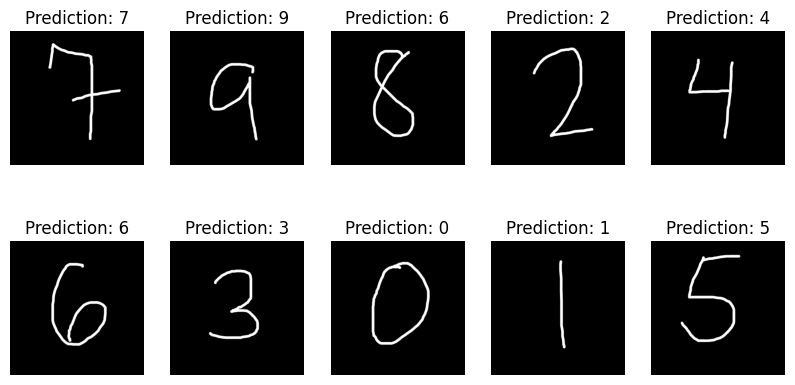

In [34]:
scripted_module = torch.jit.load('models/checkpoints/mnist-mlp-best-acc.pt')
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((28,28)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Grayscale(num_output_channels=1)])

# create figure
fig = plt.figure(figsize=(10, 5))
  
# setting values to rows and column variables
rows = 2
columns = 5

imgs = [Image.open('digits/digit0.png'), 
        Image.open('digits/digit1.png'),
        Image.open('digits/digit2.png'),
        Image.open('digits/digit3.png'),
        Image.open('digits/digit4.png'),
        Image.open('digits/digit5.png'),
        Image.open('digits/digit6.png'),
        Image.open('digits/digit7.png'),
        Image.open('digits/digit8.png'),
        Image.open('digits/digit9.png')]

for i, img in enumerate(imgs):
    img = img.convert('RGB')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    img = transform(img)
    img = torch.unsqueeze(img,0)
    img = img.to('cuda')
    y_hat = scripted_module(img)
    y_pred = torch.argmax(y_hat, dim=1)[0]
    plt.title(f"Prediction: {y_pred}")

However, it did not predict the digit $8$ correctly and predicted it to be the digit $6$. This may be because the handwriting of the digits are relatively thin compared to the MNIST dataset that it was trained on. If we make the pen thicker, we see that the model now correctly predicts the digit $8$, along with the other digits.

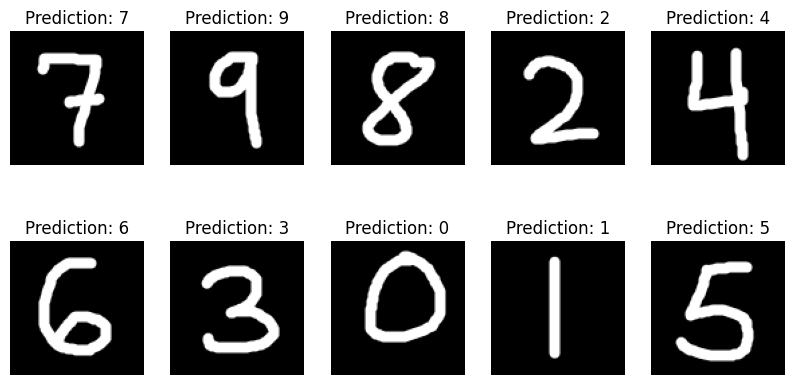

In [35]:
# create figure
fig = plt.figure(figsize=(10, 5))
  
# setting values to rows and column variables
rows = 2
columns = 5

imgs = [Image.open('digits/digit10.png'), 
        Image.open('digits/digit11.png'),
        Image.open('digits/digit12.png'),
        Image.open('digits/digit13.png'),
        Image.open('digits/digit14.png'),
        Image.open('digits/digit15.png'),
        Image.open('digits/digit16.png'),
        Image.open('digits/digit17.png'),
        Image.open('digits/digit18.png'),
        Image.open('digits/digit19.png')]
        
for i, img in enumerate(imgs):
    img = img.convert('RGB')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    img = transform(img)
    img = torch.unsqueeze(img,0)
    img = img.to('cuda')
    y_hat = scripted_module(img)
    y_pred = torch.argmax(y_hat, dim=1)[0]
    plt.title(f"Prediction: {y_pred}")